# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [20]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec


from keras.preprocessing.sequence import pad_sequences

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

# 1. Import and Clean Data

In [21]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),5000)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [22]:
review['rating_normed'] = review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']= (review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

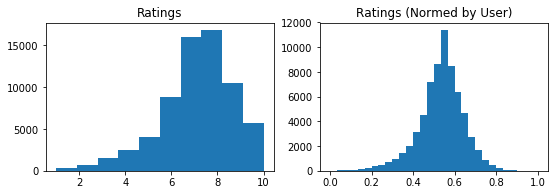

In [23]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=30)
plt.title('Ratings (Normed by User)');

## _TextBlob_

# 3. Tokenize

In [24]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


comments_train = list(review["comment"].fillna("NAN_WORD").values)

review['token'] = process_comments(comments_train, lower=True)

  3%|▎         | 2203/67160 [00:00<00:02, 22019.00it/s]

Processing text dataset


100%|██████████| 67160/67160 [00:02<00:00, 24653.21it/s]


In [25]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 34801 unique tokens


# 4. Vectorize

In [26]:
model = Word2Vec(review['token'], size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
vec_size = model.layer1_size
word_vectors = model.wv

In [27]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 11539


In [28]:
model.wv.most_similar_cosmul(positive=['paper', 'board'], negative=['box'])

[('focus', 1.0380252599716187),
 ('focusing', 1.0307649374008179),
 ('focused', 1.0223907232284546),
 ('emphasis', 0.9998076558113098),
 ('bolted', 0.9948194026947021),
 ('rely', 0.9943634867668152),
 ('territory', 0.9886487126350403),
 ('floor', 0.9770519137382507),
 ('thrive', 0.9714527726173401),
 ('rails', 0.9677637815475464)]

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

# 4. Word Embedding

In [29]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [31]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [30]:
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

Using TensorFlow backend.


NameError: name 'comments' is not defined

In [13]:
# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 200)


In [14]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

# 5. Models

In [84]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=100)
X = pd.DataFrame(tsvd.fit_transform([i for i in review.tfidf.tolist()]))
y = review['rating']

X_train_tsvd, X_test, y_train, y_test = train_test_split(X, y.astype(int).ravel(), test_size=0.33, random_state=42)

beep('submarine')

CPU times: user 10.9 s, sys: 1.42 s, total: 12.4 s
Wall time: 9.51 s


#### _I would normally spend more time evaluating the PCA component reduction, but for this project I want to evaluate cluster performance_

### _K Means Clustering_

In [85]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [86]:
%%time
km_range = range(3,15)
km_predict = []
for i in km_range:
    # Declare and fit the model.
    km_predict.append(KMeans(n_clusters=i, random_state=42).fit_predict(X_train_tsvd))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

3 completed | 4 completed | 5 completed | 6 completed | 7 completed | 8 completed | 9 completed | 10 completed | 11 completed | 12 completed | 13 completed | 14 completed | CPU times: user 54.2 s, sys: 5.18 s, total: 59.4 s
Wall time: 29.9 s


### _Spectral Clustering_

# 5. Evaluate

## _V-Measurement Test_

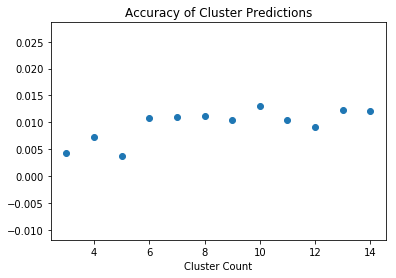

In [87]:
plt.scatter(x=[km_range],y=[v_measure_score(y_train,v) for v in km_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')

plt.show()

In [17]:
pd.crosstab(y_train, km_predict[8])

col_0,0,1,2,3,4,5,6,7,8,9,10
row_0,,,,,,,,,,,
1,4,14,0,74,3,1,0,0,12,3,1
2,13,37,0,136,8,5,0,1,24,6,3
3,26,100,1,242,11,19,1,2,45,12,8
4,44,127,5,378,24,28,2,8,77,12,12
5,86,271,18,749,52,82,6,21,133,40,26
6,172,527,47,1372,223,262,10,87,280,138,95
7,266,800,86,2230,457,500,52,204,490,218,207
8,281,675,102,2151,270,348,68,304,380,151,176
9,130,333,64,1207,85,119,65,176,204,75,59


In [18]:
from sklearn.metrics import adjusted_rand_score

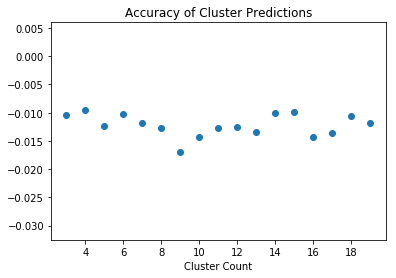

In [20]:
plt.scatter(x=[km_range],y=[adjusted_rand_score(y_train,v) for v in km_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')
# plt.ylim(0,.01)
plt.show()

In [21]:
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [16]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

In [17]:
# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [18]:
embedded_sequences = wv_layer(comment_input)

In [22]:
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [23]:
# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

In [24]:
# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          7005600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
__________

In [35]:
hist = model.fit(data, y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 517s 4ms/step - loss: 0.0613 - val_loss: 0.0525
